In [217]:
import importlib
import os
import pickle
import sys

import numpy as np
import tensorflow as tf

import general_ensemble as ensemble
from research.object_detection.custom_utils import images as img_tool

importlib.reload(img_tool)

<module 'research.object_detection.custom_utils.images' from 'D:\\project_all\\python_projects\\models\\research\\object_detection\\custom_utils\\images\\__init__.py'>

In [202]:
def load_models(model_list):
    """여러 모델을 한번에 로드한다.

    :param model_list: 모델 경로가 적힌 리스트
    :return: SavedModel에서 로드된 모델들 dict
    """
    models = {}
    for model_path in model_list:
        model = tf.saved_model.load(model_path)
        model_name = os.path.split(model_path)[1]
        models[model_name] = model
    return models


def convert_label_id_to_name(ids, labelmap):
    """인식 결과를 가독성 있는 문자열로 반환.

    :param ids: int 원소들의 리스트. 각 원소는 `labelmap`에 정해진 id이다.
        detector의 결과 중 `pred['detection_classes'][0]`이라고 보면 된다.
    :param labelmap: str 원소들의 리스트. 각 원소는 label명이고, 원소의 인덱스가 `ids`의 id에 대응.
    :return: 물체 이름으로 변환된 인식 결과들.
    """
    return np.array([labelmap[int(lbl_id)] for lbl_id in ids])


def boxes_for_ensemble(pred):
    """detector 검출 결과를 general_ensemble이 요구하는 데이터 형식으로 변환.

    :param dict pred: 검출기 하나의 결과.
        `detection_boxes`, `detection_classes`, `detection_scores` 키를 포함하고 있어야 한다.
        `detection_boxes`: [ymin, xmin, ymax, xmax], 이미지 크기에 상대적인 좌표.
        `detection_scores`: [0, 1]의 confidence score.
        `detection_classes`: int형의 사전에 정의된 사물 id.
    :return:
        [bbox_xcen, bbox_ycen, bbox_width, bbox_height, class_id, score] 형식의 1개 이상의 검출 결과 리스트.
    """
    bboxes = pred['detection_boxes'][0]  # relative pos
    classes = pred['detection_classes'][0]
    scores = pred['detection_scores'][0]

    det_for_detector = []
    for b, c, s in zip(bboxes, classes, scores):
        ymin = b[0].numpy()
        xmin = b[1].numpy()
        ymax = b[2].numpy()
        xmax = b[3].numpy()
        width = xmax - xmin
        height = ymax - ymin
        xcen = xmin + width / 2
        ycen = ymin + height / 2
        det_for_detector.append([xcen, ycen, width, height, c.numpy(), s.numpy()])
    return det_for_detector


def boxes_for_drawer(dets_from_ensemble):
    """앙상블 결과를 `draw_boxes` 함수가 요구하는 형식으로 변환.

    :param dets_from_ensemble: 앙상블 결과.
    :return: 단일 detector 모델이 출력하는 형식과 유사함.
    """
    ens_bboxes = []
    ens_classes = []
    ens_scores = []
    for det in dets_from_ensemble:
        # bbox 좌표 재조정.
        xcen, ycen, width, height, label, score = det
        xmin = (xcen - width / 2)
        xmax = (xcen + width / 2)
        ymin = (ycen - width / 2)
        ymax = (ycen + width / 2)
        ens_bboxes.append(np.array([ymin, xmin, ymax, xmax]))
        ens_classes.append(label)
        ens_scores.append(score)
    ens_bboxes = np.array(ens_bboxes)
    ens_classes = np.array(ens_classes)
    ens_scores = np.array(ens_scores)
    return ens_bboxes, ens_classes, ens_scores


def ensemble_detect(image_path, models, weights):
    """사물 인식 모델들의 앙상블 결과를 이미지에 그린다.

    :param image_path: jpeg 이미지 경로.
    :param models: detector들의 dict
    :param weights: mAP가 높은 모델은 중요하게 취급하려고 넣은 모델별 가중치.
    :return: annotation들이 그려진 이미지
    """
    # 입력 이미지 detector에 맞게 변환.
    if not os.path.exists(image_path):
        print(f'The image does not exist.')
        sys.exit(1)

    image_tensor = img_tool.load_img(image_path)
    image_tensor = tf.expand_dims(image_tensor, axis=0)

    # 각 detector in `models` 결과 도출하기.
    preds = []
    for k, v in models.items():
        pred = v.signatures['serving_default'](image_tensor)
        preds.append(pred)

    # 앙상블 결과 도출하기.
    dets_for_ensemble = []
    for pred in preds:
        dets_for_detector = boxes_for_ensemble(pred)
        dets_for_ensemble.append(dets_for_detector)
    ensemble_results = ensemble.general_ensemble(dets_for_ensemble, weights=weights)

    # 앙상블 결과를 그리기 함수에 맞는 형식으로 변환.
    ens_bboxes, ens_classes, ens_scores = boxes_for_drawer(ensemble_results)

    # 앙상블 결과의 시각화 - 단점: 재현율이 하락함. 장점: 정밀도가 상승함.
    ens_names = convert_label_id_to_name(ens_classes, labels)
    image_with_bbox = img_tool.draw_boxes(
        image_tensor.numpy()[0], ens_bboxes, ens_names, ens_scores)
    # img_tool.display_image(image_with_bbox)  # 실제 그리기가 필요하면 넣어야 함.
    return image_with_bbox

In [33]:
model_dir = '../savedmodels'
model_list = [
    'retinanet_resnet50_v1_fpn_1024x1024',  # 38.3
    'retinanet_resnet101_v1_fpn_1024x1024',  # 39.5
    'efficientdet_d1',  # 38.4
]

model_pathes = [os.path.join(model_dir, model) for model in model_list]
for path in model_pathes:
    if not os.path.exists(path):
        print(f'{path} does not exist.')
        sys.exit(1)

models = load_models(model_pathes)

In [34]:
weights = [38.3, 39.5, 38.4]  # mAP 기준으로 산출
weights /= np.sum(weights)

In [ ]:
# label map
labels = []
label_map_path = 'coco_labelmap'
with open(label_map_path, 'r') as fin:
    content = fin.readlines()
start_idx = 3
offset = 5
for i in range(91):
    line = content[start_idx + offset * i]
    label = line[17:-2]
    labels.append(label)

In [210]:
image_dir = '../test_images/ensemble-test'
pred_out_dir = '../test_images/ensemble-result'

for image_path in os.scandir(image_dir):
    image_path = os.path.abspath(image_path)
    image_with_bbox = ensemble_detect(image_path, models, weights)
    basename = os.path.split(image_path)[1]
    tf.keras.preprocessing.image.save_img(
        os.path.join(pred_out_dir, basename),
        image_with_bbox)



Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using defaul

KeyboardInterrupt: 

Font not found, using default font.


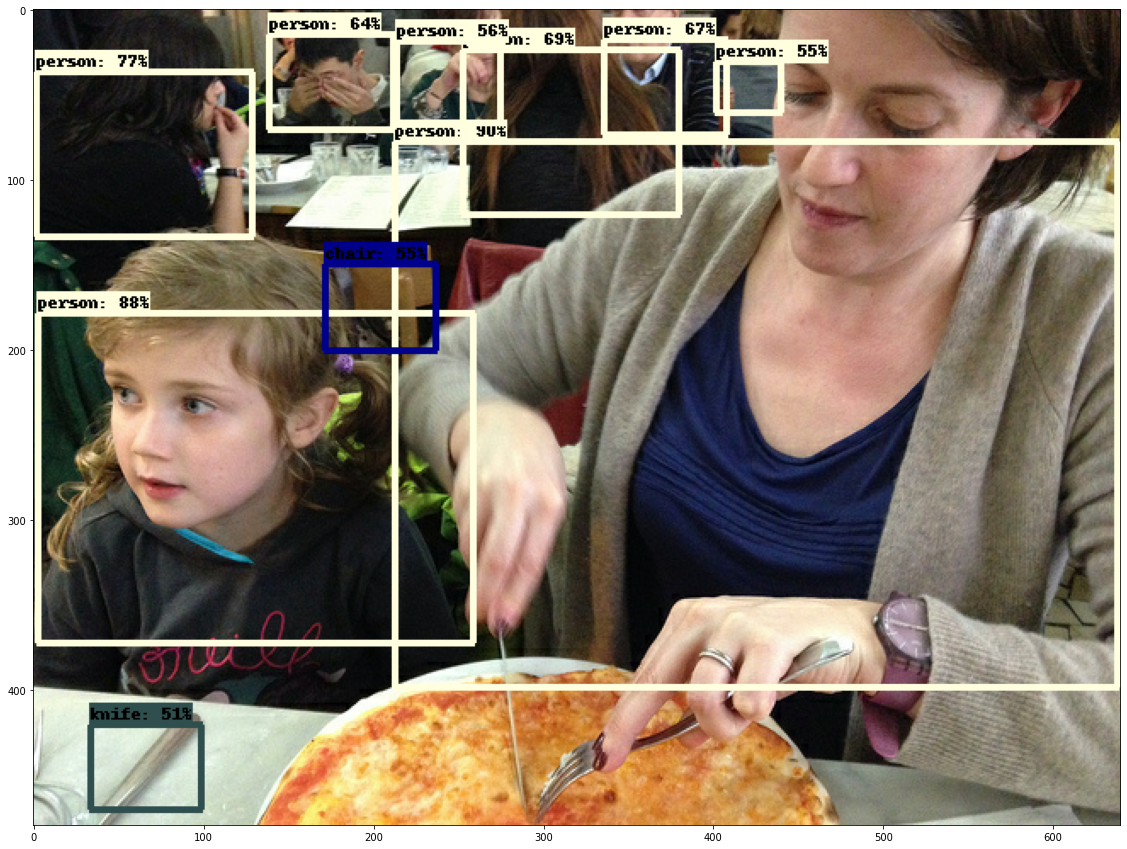

In [201]:
# model1 = {'retinanet_resnet50_v1_fpn_1024x1024': models['retinanet_resnet50_v1_fpn_1024x1024']}
# model2 = {'retinanet_resnet101_v1_fpn_1024x1024': models['retinanet_resnet101_v1_fpn_1024x1024']}
# model3 = {'efficientdet_d1': models['efficientdet_d1']}
#
# ensemble_detect(
#     image_path,
#     model3,
#     [1])

In [219]:
pickle_path = '../test_images/ensemble_result.pickle'
with open(pickle_path, 'rb') as fin:
    dets_on_testset = pickle.load(fin)

In [246]:
for example in dets_on_testset:
    image_path = os.path.join(image_dir, example['file_name'])
    image_tensor = img_tool.load_img(image_path)

    # testset에 대해 하나의 디텍터가 내놓은 결과들
    for model_num, pred_each_voter in enumerate(example['preds_voters']):
        print(f'{model_num} is predicting on the testset.')
        bboxes = pred_each_voter['detection_boxes'].numpy()[0]
        classes = pred_each_voter['detection_classes'].numpy()[0]
        lbl_names = convert_label_id_to_name(classes, labels)
        scores = pred_each_voter['detection_scores'].numpy()[0]

        image_with_bbox = img_tool.draw_boxes(
            image_tensor.numpy(), bboxes, lbl_names, scores)

        tf.keras.preprocessing.image.save_img(
            os.path.join(f'../test_images/model{model_num}-result', example['file_name']),
            image_with_bbox)

Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using default font.
Font not found, using defaul

In [240]:
pred_each_voter['detection_boxes'].numpy().shape

(1, 100, 4)